# Data Challenge 1 - Employee Retention

Employee turn-over is a very costly problem for companies. The cost of replacing an employee
if often larger than 100K USD, taking into account the time spent to interview and find a
replacement, placement fees, sign-on bonuses and the loss of productivity for several months.
0t is only natural then that data science has started being applied to this area. Understanding
why and when employees are most likely to leave can lead to actions to improve employee
retention as well as planning new hiring in advance. This application of DS is sometimes called
people analytics or people data science (if you see a job title: people data scientist, this is your
job).

In this challenge, you have a data set with info about the employees and have to predict when
employees are going to quit by understanding the main drivers of employee churn.

We got employee data from a few companies. We have data about all employees who joined
from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the
company as of 2015/12/13 or they have quit. Beside that, we have general info about the
employee, such as avg salary during her tenure, dept, and yrs of experience.

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from datetime import datetime
import warnings
import time
from scipy import stats
import itertools
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler, Imputer, scale
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, learning_curve, KFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
from yellowbrick.regressor import ResidualsPlot

## Load the data and get a look at some of the available features
Data includes information on employee ID, company ID, department the employee works/ed in, seniority (years working before behing hired), salary, his/her join date and the date s/he quit (if available)

In [2]:
df = pd.read_csv('employee_retention_data.csv',dtype={"value": float})
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


#### What type of data are we working with?

In [3]:
df.dtypes

employee_id    float64
company_id       int64
dept            object
seniority        int64
salary         float64
join_date       object
quit_date       object
dtype: object

Float and integers - but there are dates, so they will need to be converted to datetime

## Challenge 1) Employee Headcount
Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate
employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13.
That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have
already quit, then company headcount on 2012/03/02 for company 1 would be 1000.
You should create a table with 3 columns: day, employee_headcount, company_id.

In [4]:
df['join_date']=pd.to_datetime(df['join_date'])
df['quit_date']=pd.to_datetime(df['quit_date'])

In [5]:
date_range = pd.date_range(start='2011/01/24',end='2015/12/13')

df['latest_date'] = df['quit_date']
current = datetime.strptime('13/12/15', '%d/%m/%y')
df['latest_date'].fillna(value=current,inplace=True)

headcount = pd.DataFrame(columns=['day','company_id','employee_headcount'])
for day in date_range:
    tmp = pd.DataFrame(df[(df['join_date'] <= day) & (day < df['latest_date'])].groupby('company_id')['employee_id'].count())
    tmp['day'] = day
    tmp.rename(index = str,columns={'employee_id':'employee_headcount'},inplace=True)
    tmp.reset_index(inplace=True)
    headcount = headcount.append(tmp)

df.drop(['latest_date'], axis=1, inplace=True)    
headcount.set_index('day',inplace=True)
headcount.head()

,company_id,employee_headcount
day,,
2011-01-24,1,25
2011-01-24,2,17
2011-01-24,3,9
2011-01-24,4,12
2011-01-24,5,5


#### What does this data look like / indicate?

company_id
1     AxesSubplot(0.125,0.125;0.775x0.755)
10    AxesSubplot(0.125,0.125;0.775x0.755)
11    AxesSubplot(0.125,0.125;0.775x0.755)
12    AxesSubplot(0.125,0.125;0.775x0.755)
2     AxesSubplot(0.125,0.125;0.775x0.755)
3     AxesSubplot(0.125,0.125;0.775x0.755)
4     AxesSubplot(0.125,0.125;0.775x0.755)
5     AxesSubplot(0.125,0.125;0.775x0.755)
6     AxesSubplot(0.125,0.125;0.775x0.755)
7     AxesSubplot(0.125,0.125;0.775x0.755)
8     AxesSubplot(0.125,0.125;0.775x0.755)
9     AxesSubplot(0.125,0.125;0.775x0.755)
Name: employee_headcount, dtype: object

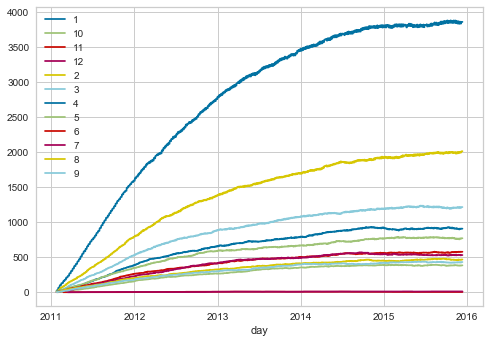

In [6]:
comps = [str(i) for i in range(13)]
headcount[headcount['company_id'].isin(comps)].groupby('company_id')['employee_headcount'].plot(legend=True)

Important to note: companies 11 & 12 have few employees across five years -- maybe startups? These companies range in size, but company 1 has seen the highest growth. This may affect final model.

## Challenge 2) What is driving employee churn?
### Things to look for: important features & if can we predict when someone will churn
What is churn? Church is the measure of how employees are leaving their jobs. We can assume that things like salary or seniority may play a part in employee retention, but we can make more inferences by first exploring the data and then choosing an appropriate model to examine both features and the ability to predict when someone might leave a company.

### Add important features

#### Duration of employment

In [7]:
def duration(df,start,quit):
    df[start] = pd.to_datetime(df[start])
    df[quit] = pd.to_datetime(df[quit])
    # Create temp column to contain current date to treat non-quitting employee duration (to be dropped later)
    df['latest_date'] = df[quit]
    current = datetime.strptime('13/12/15', '%d/%m/%y')
    df['latest_date'].fillna(value=current,inplace=True)
    df['duration'] = df['latest_date'] - df[start]
    df.drop(['latest_date'], axis=1, inplace=True)
    return df

df_ = duration(df,'join_date','quit_date')
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,duration
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585 days
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340 days
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,426 days
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389 days
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040 days


To ensure duration column is integer

In [8]:
# Convert timedelta to an integer value for use in analysis
df['duration'] = df['duration'] / (np.timedelta64(1, 'D'))

#### Quit or has not quit (binary)

In [9]:
def quit_dummies(df, column):
    
    quit1 = df[column].notnull()
    quit2 = pd.get_dummies(quit1)
    quit2.columns = ['not_quit', 'quit']
    df = pd.concat([df, quit2], axis=1)
    df.drop(['not_quit'], axis=1, inplace=True)
    
    return df

df = quit_dummies(df,'quit_date')
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,duration,quit
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0,1
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0,1
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,426.0,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0,1
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0,1


## Exploratory Data Analysis

#### Salary Distribution

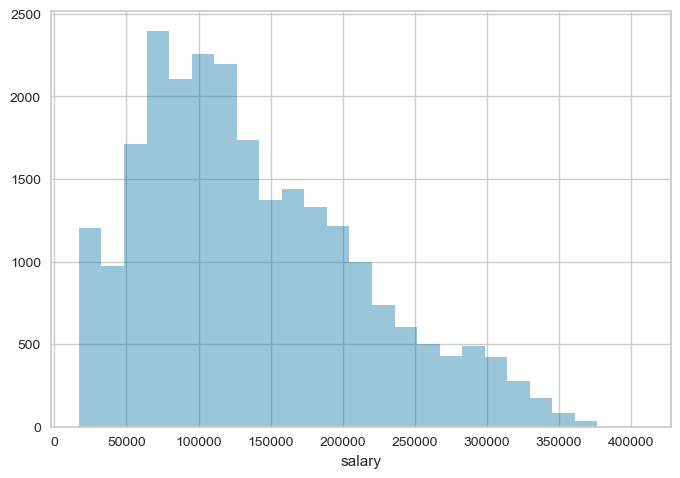

In [10]:
salary = df[df['salary'].notnull()]
fig = plt.figure(dpi=100)
sns.distplot(salary['salary'], bins=25, kde=False)

Just a quick snapshot of salary distribution - most of the jobs hover around the 100k mark

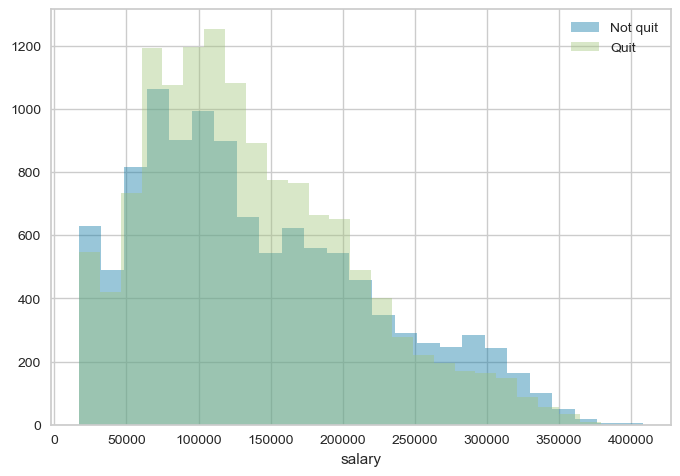

In [11]:
def salary_churn_plot(df):

    salary_churn = df['salary'][df['quit'] == 1].reset_index()
    salary_stay = df['salary'][df['quit'] == 0].reset_index()
    salary_churn = salary_churn[salary_churn['salary'].notnull()]
    salary_stay = salary_stay[salary_stay['salary'].notnull()]
    
    fig = plt.figure(dpi=100)
    sns.distplot(salary_stay['salary'], bins=25, kde=False, label = 'Not quit')
    sns.distplot(salary_churn['salary'], bins=25, kde=False, label = 'Quit')
    plt.legend()
    
salary_churn_plot(df)

I wanted to see there was a change in salary distribution between the two groups (quit vs didn't quit). However, both seem to follow the same trend.

#### Does seniority have an effect?

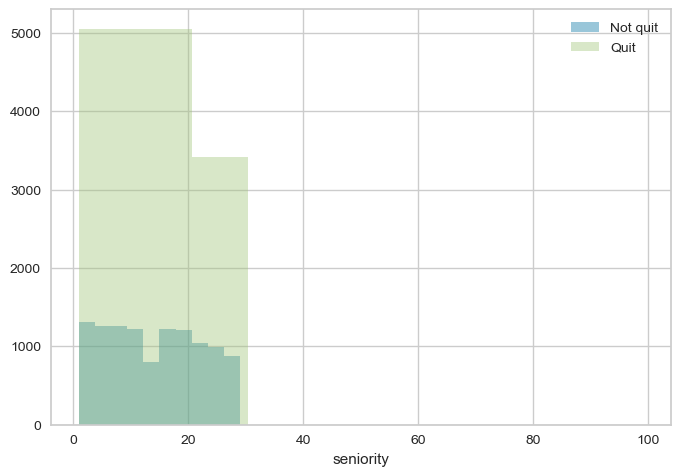

In [12]:
def seniority_churn_plot(df):

    seniority_churn = df['seniority'][df['quit'] == 1].reset_index()
    seniority_stay = df['seniority'][df['quit'] == 0].reset_index()
    seniority_churn = seniority_churn[seniority_churn['seniority'].notnull()]
    seniority_stay = seniority_stay[seniority_stay['seniority'].notnull()]
    
    fig = plt.figure(dpi=100)
    sns.distplot(seniority_stay['seniority'], bins=10, kde=False, label = 'Not quit')
    sns.distplot(seniority_churn['seniority'], bins=10, kde=False, label = 'Quit')
    plt.legend()
    
seniority_churn_plot(df)

Initial observations: there are a few outliers in the not quit (perhaps CEOs), but there is nothing of note in distribution pattern

#### What do these factors look like with department?

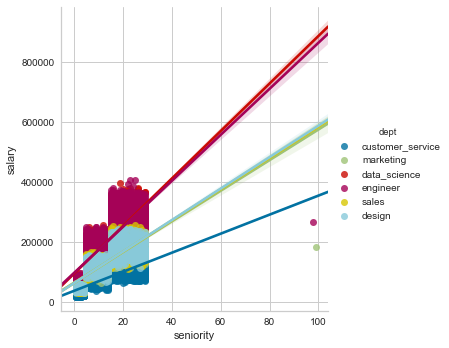

In [13]:
sns.lmplot(x='seniority', y='salary', hue='dept', 
           data=df)

Looking at all factors together, it is obvious that engineers make more money than say design or customer service and that salary gets better with seniority. There could be come collinearity in the model that will need to be addressed.

#### Let's look at the differences between quit vs not quitting employees

In [14]:
df['quit'].value_counts()

1    13510
0    11192
Name: quit, dtype: int64

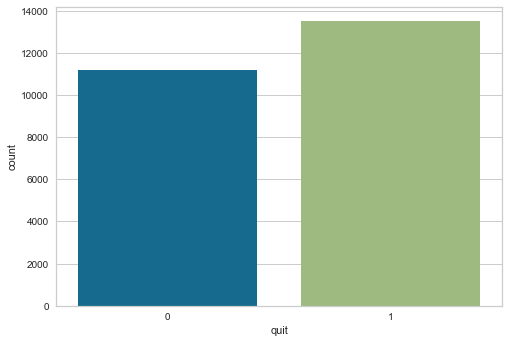

In [15]:
sns.countplot(df['quit'])
plt.show()

The dataset itself is almost even for quit (1) vs not quit (0)

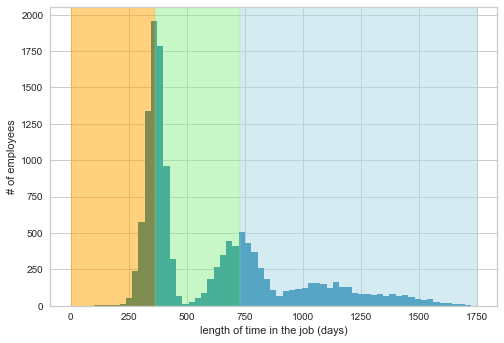

In [16]:
df.loc[df['quit']==1,'duration'].hist(bins=60)
plt.ylabel('# of employees')
plt.xlabel('length of time in the job (days)')
plt.axvspan(0, 365, alpha=0.5, color='orange')
plt.axvspan(365, 730, alpha=0.5, color='lightgreen')
plt.axvspan(730, 1750, alpha=0.5, color='lightblue')

Now we are seeing some intriguing patterns. When it comes to churn, it appears that most people end up leaving right around one year after joining (orange). A second group leaves around the two year mark (green), while a third group is more leveled off after 2 years (blue). The further an employee stays at the company, the less it seems likely for churn.

In [17]:
df.groupby('quit').mean()

,employee_id,company_id,seniority,salary,duration
quit,,,,,
0,501079.237759,3.387688,14.123392,141238.473910,527.039224
1,502039.463138,3.459511,14.131458,135652.405625,613.486825


Mean salary of those that quit is about 60,000 less than those who stay.
Seniority does not appear to factor

Text(0.5,0,'salary')

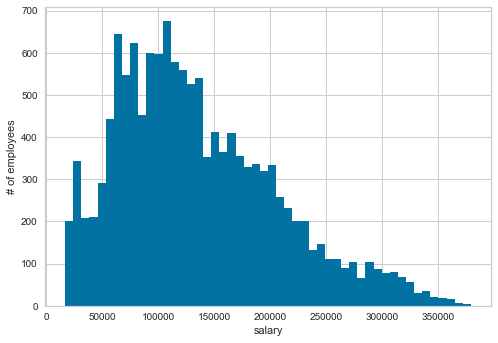

In [18]:
df.loc[df['quit']==1,'salary'].hist(bins=50)
plt.ylabel('# of employees')
plt.xlabel('salary')

Higher salaries have fewer employees that quit - almost 6x more for people in the 100k-150k bracket

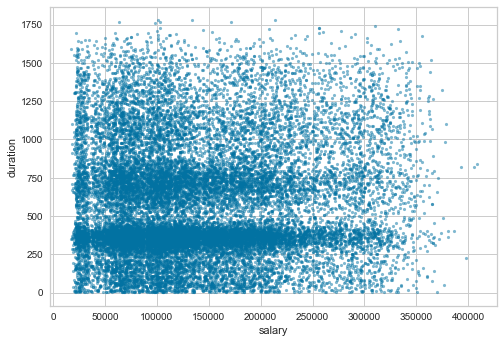

In [19]:
sns.regplot(x='salary', 
            y='duration', 
            data=df,
            fit_reg=False,
            scatter_kws={'s': 10, 'alpha': 0.5})
plt.show()

No clear trend based off salary vs how long they stayed

In [20]:
df.groupby('dept').mean()

,employee_id,company_id,seniority,salary,duration,quit
dept,,,,,,
customer_service,498143.365251,3.441721,14.171133,82245.424837,561.547821,0.554902
data_science,500726.793103,3.440439,14.189028,206885.893417,606.593417,0.527273
design,500995.411594,3.386957,14.197826,137460.869565,573.282609,0.563768
engineer,502594.180143,3.429872,14.172122,205544.548016,602.546065,0.512031
marketing,502677.877802,3.383644,13.993685,135598.042311,559.504578,0.562993
sales,510257.236129,3.427175,13.979823,135912.358134,553.014502,0.570933


Text(0,0.5,'# employees')

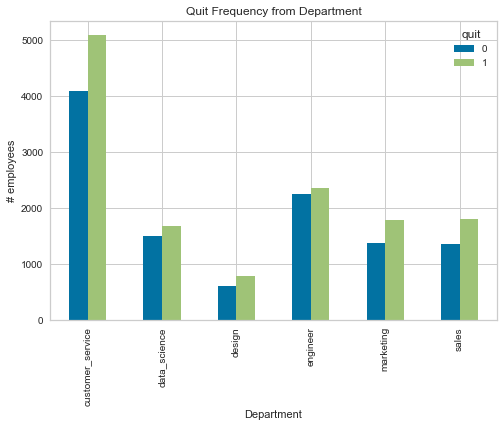

In [21]:
pd.crosstab(df.dept,df.quit).plot(kind='bar')
plt.title('Quit Frequency from Department')
plt.xlabel('Department')
plt.ylabel('# employees')

In [22]:
df['dept'].unique()

array(['customer_service', 'marketing', 'data_science', 'engineer',
       'sales', 'design'], dtype=object)

Customer service looks to be higher in their quit rate than other departments, but they also have the most employees

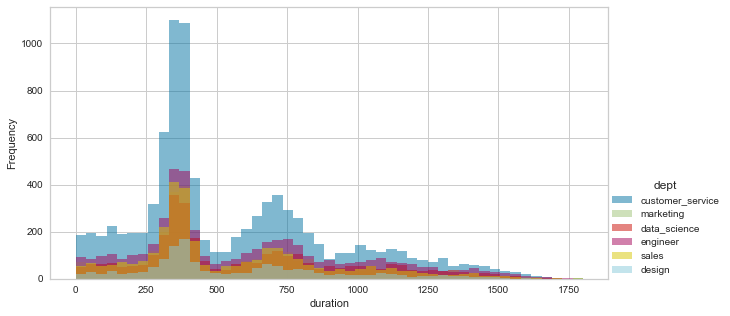

In [23]:
plt.figure(figsize=(10,5))
for d in df['dept'].unique():
    sns.distplot(
        df[df['dept']==d]['duration'], 
        bins=np.linspace(0, 1800, 50),
        kde=False,
        hist_kws={'rwidth': 1., 
                  'alpha': 0.5, 
                  'linewidth': 2,
                  'label': d})
plt.legend(loc=(1,0), title='dept')
plt.ylabel('Frequency')
plt.show()

Department duration seems to follow similar trends

In [24]:
df.groupby('company_id').mean()

,employee_id,seniority,salary,duration,quit
company_id,,,,,
1,501773.268324,14.141999,152167.570115,578.114306,0.544544
2,503864.736618,14.297489,155728.090952,584.572241,0.522501
3,496656.524918,14.054565,122118.588578,564.431430,0.556930
4,513380.616392,14.023763,122721.144520,563.377789,0.559166
5,507257.065527,14.474644,123348.717949,570.156125,0.560114
6,490152.278079,14.089853,119925.639040,567.033308,0.551510
7,501416.076797,13.906046,121582.516340,582.803922,0.565359
8,493358.904489,13.867240,122284.622732,563.765043,0.553009
9,505596.132154,13.778356,123905.306972,569.098855,0.550468


Text(0,0.5,'# employees')

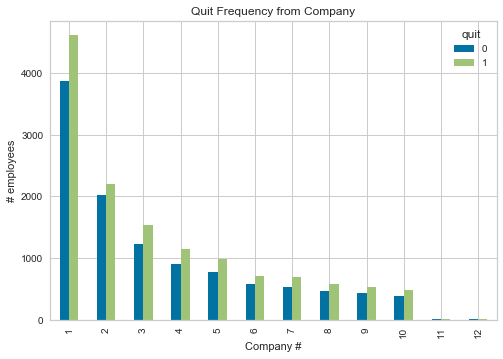

In [25]:
pd.crosstab(df.company_id,df.quit).plot(kind='bar')
plt.title('Quit Frequency from Company')
plt.xlabel('Company #')
plt.ylabel('# employees')

Company 11 seems to have the highest quit rate -- but they have fewer employees than other companies. Looking at 

## Feature Engineering: Prepare data for a model (turn categorical into binary)

#### One hot encode department

In [26]:
def department_dummies(df, column):
    
    dept = pd.get_dummies(df[column])
    dept.columns = ['customer_service', 'data_science', 'design', 'engineer', 'marketing', 'sales']
    df = pd.concat([df, dept], axis=1)
    df.drop([column], axis=1, inplace=True)
    
    return df

df = department_dummies(df, 'dept')
df.head()

,employee_id,company_id,seniority,salary,join_date,quit_date,duration,quit,customer_service,data_science,design,engineer,marketing,sales
0,13021.0,7,28,89000.0,2014-03-24,2015-10-30,585.0,1,1,0,0,0,0,0
1,825355.0,7,20,183000.0,2013-04-29,2014-04-04,340.0,1,0,0,0,0,1,0
2,927315.0,4,14,101000.0,2014-10-13,NaT,426.0,0,0,0,0,0,1,0
3,662910.0,7,20,115000.0,2012-05-14,2013-06-07,389.0,1,1,0,0,0,0,0
4,256971.0,2,23,276000.0,2011-10-17,2014-08-22,1040.0,1,0,1,0,0,0,0


#### One hot encode company

In [27]:
def company_id_dummies(df, column):
    
    c_id = pd.get_dummies(df[column])
    c_id.columns = ['company_1', 'company_2', 'company_3', 'company_4', 'company_5', 'company_6','company_7', 'company_8', 'company_9', 'company_10', 'company_11', 'company_12']
    df = pd.concat([df, c_id], axis=1)
    df.drop([column], axis=1, inplace=True)
    
    return df

df = company_id_dummies(df, 'company_id')
df.head()

,employee_id,seniority,salary,join_date,quit_date,duration,quit,customer_service,data_science,design,...,company_3,company_4,company_5,company_6,company_7,company_8,company_9,company_10,company_11,company_12
0,13021.0,28,89000.0,2014-03-24,2015-10-30,585.0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,825355.0,20,183000.0,2013-04-29,2014-04-04,340.0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,927315.0,14,101000.0,2014-10-13,NaT,426.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,662910.0,20,115000.0,2012-05-14,2013-06-07,389.0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,256971.0,23,276000.0,2011-10-17,2014-08-22,1040.0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Establish a Dataframe for only those that quit - in case a linear model is used for prediction of duration, there will be no need to examine those that stay (we only want to look at the features used to drive churn)

In [28]:
df_quit = df.dropna(axis=0, how='any')
df_quit.head()

,employee_id,seniority,salary,join_date,quit_date,duration,quit,customer_service,data_science,design,...,company_3,company_4,company_5,company_6,company_7,company_8,company_9,company_10,company_11,company_12
0,13021.0,28,89000.0,2014-03-24,2015-10-30,585.0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,825355.0,20,183000.0,2013-04-29,2014-04-04,340.0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,662910.0,20,115000.0,2012-05-14,2013-06-07,389.0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,256971.0,23,276000.0,2011-10-17,2014-08-22,1040.0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,509529.0,14,165000.0,2012-01-30,2013-08-30,578.0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0


#### Does the length of the three duration groups play a role? Let's one hot encode these too.

In [29]:
def length_of_stay_dummies(df, column):
    
    df['less_than_year'] = (df[column] <= 365)
    df['less_than_year'] = df['less_than_year'].astype(int)
    df['between_one_two_years'] = (df[column] > 365) & (df[column] <= 730)
    df['between_one_two_years'] = df['between_one_two_years'].astype(int)
    df['more_than_two_years'] = (df[column] > 730)
    df['more_than_two_years'] = df['more_than_two_years'].astype(int)
    
    return df

df_quit = length_of_stay_dummies(df_quit, 'duration')
df_quit.head()

,employee_id,seniority,salary,join_date,quit_date,duration,quit,customer_service,data_science,design,...,company_6,company_7,company_8,company_9,company_10,company_11,company_12,less_than_year,between_one_two_years,more_than_two_years
0,13021.0,28,89000.0,2014-03-24,2015-10-30,585.0,1,1,0,0,...,0,1,0,0,0,0,0,0,1,0
1,825355.0,20,183000.0,2013-04-29,2014-04-04,340.0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,662910.0,20,115000.0,2012-05-14,2013-06-07,389.0,1,1,0,0,...,0,1,0,0,0,0,0,0,1,0
4,256971.0,23,276000.0,2011-10-17,2014-08-22,1040.0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
5,509529.0,14,165000.0,2012-01-30,2013-08-30,578.0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0


### Look for correlation between quitting and other metrics
Need to remove all employees still working for the companies

In [30]:
sns.set(style='whitegrid', context='notebook')
cols = ['seniority','salary','duration','customer_service','data_science','design','engineer','marketing','sales','company_1', 'company_2', 'company_3', 'company_4', 'company_5', 'company_6','company_7', 'company_8', 'company_9', 'company_10', 'company_11', 'company_12','between_one_two_years','more_than_two_years','less_than_year']

#### A correlation matrix can identify any collinearity amongst variables

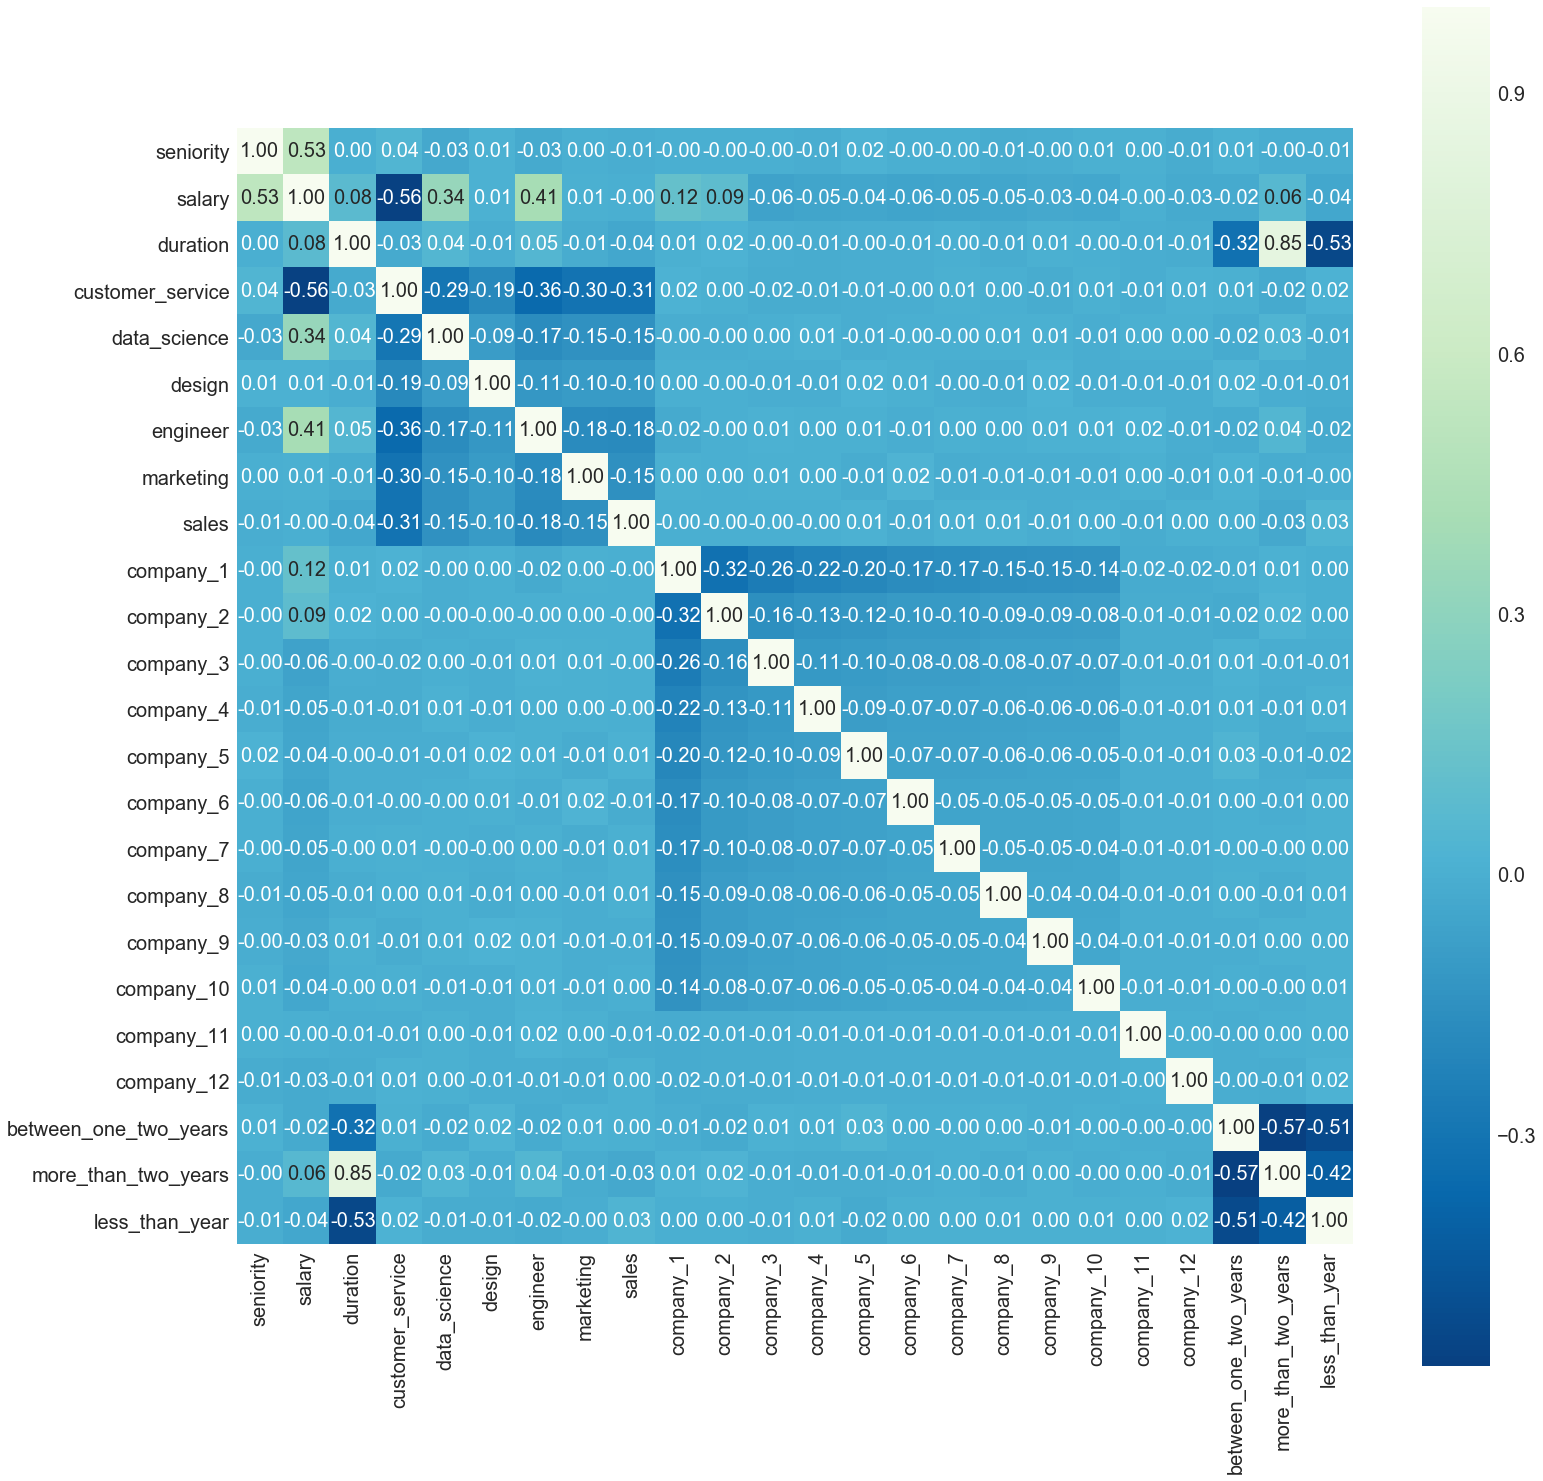

In [31]:
cm2 = np.corrcoef(df_quit[cols].values.T)
fig = sns.set(font_scale=2)
plt.subplots(figsize=(25,25))
hm2 = sns.heatmap(cm2,
    cbar=True,
    annot=True,
    square=True,
    fmt='.2f',
    annot_kws={'size': 20},
    yticklabels=cols,
    xticklabels=cols,
    cmap='GnBu_r')
#plot_url = py.plot(hm)
plt.show()

Since I one hot encoded many of the features, most of the matrix is useless and needs to be reduced. Important to take from this is that these categories are independent of each other (i.e. separate companies)

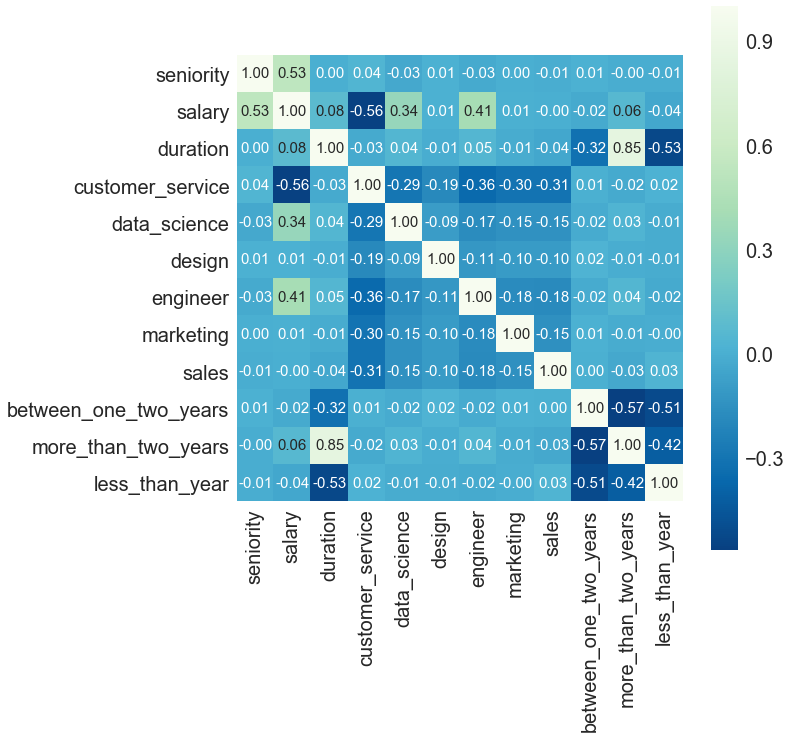

In [32]:
cols2 = ['seniority','salary','duration','customer_service','data_science','design','engineer','marketing','sales','between_one_two_years','more_than_two_years','less_than_year']
cm2 = np.corrcoef(df_quit[cols2].values.T)
fig = sns.set(font_scale=2)
plt.subplots(figsize=(10,10))
hm2 = sns.heatmap(cm2,
    cbar=True,
    annot=True,
    square=True,
    fmt='.2f',
    annot_kws={'size': 15},
    yticklabels=cols2,
    xticklabels=cols2,
    cmap='GnBu_r')
#plot_url = py.plot(hm)
plt.show()

Some collinearity exists

## Models: What is best to choose?
Our challenge has two goals. 1) To identify the factors that heavily influence churn and 2) to predict when an employee may quit. These are two separate types of tests, a classifier for feature importance and regressor for prediction. To identify feature importances we can look to a random forest classifier and for prediction, we can examine a linear regression model to predict employee duration at a company.

### Random Forest Classifier
In the interest of looking for features that drive churn across all the companies, removal of the company_id is necessary so there is no bias per company

In [33]:
X = df[['duration','seniority','salary','customer_service','data_science','design','engineer','marketing','sales']]
y = df[['quit']]

Set-up model with 70/30% training/test

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Run the Random Forest

In [35]:
rf_clf = RandomForestClassifier(n_estimators=30, max_depth=10, random_state=1)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

#### Check accuracy with a learning curve

In [36]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure(dpi=100)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best",fontsize=12)
    
    return plt

<module 'matplotlib.pyplot' from '/Users/DAlfego/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

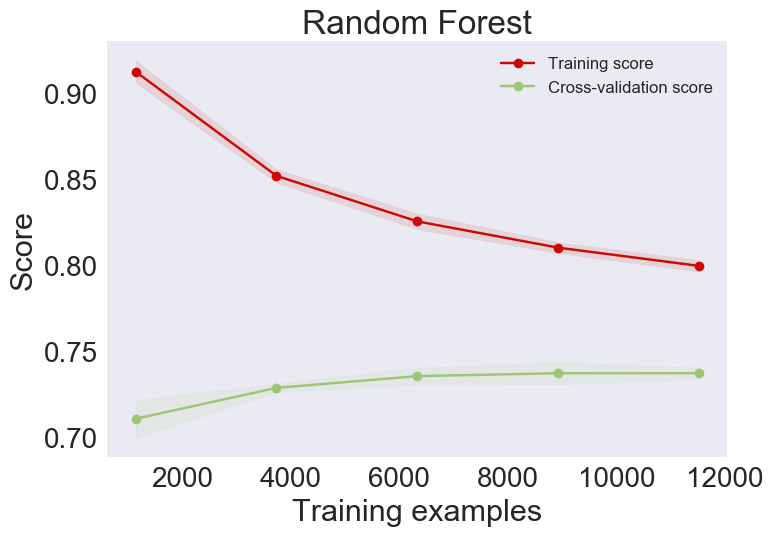

In [37]:
plot_learning_curve(rf_clf, 'Random Forest', X_train, y_train, n_jobs=2)

The model appears to be performing okay right now - not too high evidence of overfitting

In [38]:
y_predict = rf_clf.predict(X_test)
accuracy_score(y_test, y_predict)

0.75509377951693424

The model predicts an employee quit with 75% accuracy - this isn't too bad!

#### A confusion matrix can tell us more about what this accuracy means

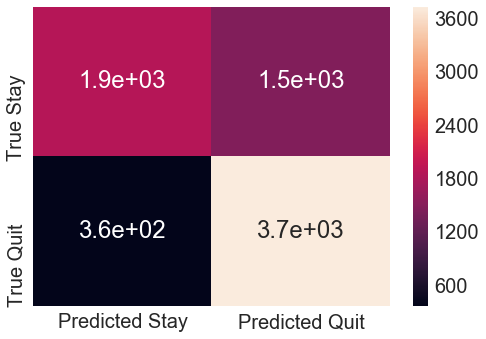

In [39]:
cm = pd.DataFrame(confusion_matrix(y_test, y_predict),columns=['Predicted Stay','Predicted Quit'], index=['True Stay','True Quit'])
sns.heatmap(cm, annot=True)

The diagonal tells us the true positive counts, but the false pos/neg counts seems to be a little high.

#### What features are important?

In [40]:
def example_feature_importance(X_train, y_train, model, labels_dict):
    
    model.fit(X_train, y_train)
    feature_importance = (np.vstack((np.arange(len(rf_clf.feature_importances_)), rf_clf.feature_importances_)).T)
    ranking = feature_importance[feature_importance[:,1].argsort()[::-1]]
    ranked_list = []
    ranked_labels = []
    
    for rank, importance in ranking:
        print(labels_dict[rank], importance)
        ranked_list.append(importance)
        ranked_labels.append(labels_dict[rank])
        
    
    f, ax = plt.subplots(figsize=(11, 9))
    ax = sns.barplot(x=ranked_list, y=ranked_labels)
    
    return ax

Duration 0.850921250182
Salary 0.0952268878071
Seniority 0.0410245477166
Engineer 0.00305288682601
Data Science 0.00244411790651
Marketing 0.00224935074566
Sales 0.00194945112393
Customer Service 0.00159756414083
Design 0.00153394355152


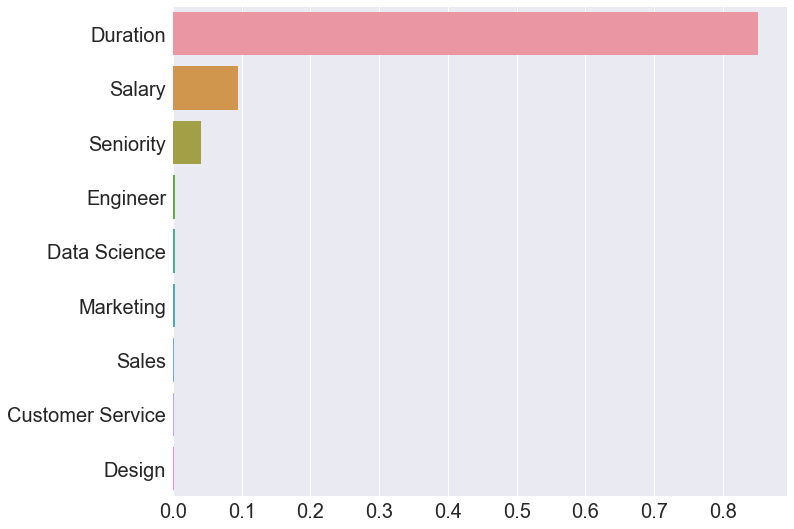

In [41]:
labels_dict = {0: 'Duration',
              1: 'Seniority',
              2: 'Salary',
              3: 'Customer Service',
              4: 'Data Science',
              5: 'Design',
              6: 'Engineer',
              7: 'Marketing',
              8: 'Sales'}

example_feature_importance(X_train, y_train, rf_clf, labels_dict)


As expected, the main feature that drive the ability to predict churn is total time spent with the company by a wide margin. Salary and seniority are the next two important features, but significantly less so. Department does not seem to play a role.

### What about predicting how long until someone may churn?
For this wee look to a linear regression model. Since I saw some evidence of collinearity, I will use a Ridge Regression model.

#### Scale the continuous data first

In [42]:
scaler = MinMaxScaler()

df_quit_scaled = df_quit
df_quit_scaled['salary'] = scaler.fit_transform(df_quit_scaled[['salary']])
df_quit_scaled['seniority'] = scaler.fit_transform(df_quit_scaled[['seniority']])
df_quit_scaled['duration'] = scaler.fit_transform(df_quit_scaled[['duration']])

#### Here, the predictor variable will be 'duration' and 'quit' can be removed since the model will only be examining those who quit to predict, not those that remain.

In [43]:
X2 = df_quit_scaled[['seniority','salary','customer_service','data_science','design','engineer','marketing','sales','between_one_two_years','more_than_two_years','less_than_year']]
y2 = df_quit_scaled[['duration']]
X2.head()

,seniority,salary,customer_service,data_science,design,engineer,marketing,sales,between_one_two_years,more_than_two_years,less_than_year
0,0.275510,0.198895,1,0,0,0,0,0,1,0,0
1,0.193878,0.458564,0,0,0,0,1,0,0,0,1
3,0.193878,0.270718,1,0,0,0,0,0,1,0,0
4,0.224490,0.715470,0,1,0,0,0,0,0,1,0
5,0.132653,0.408840,0,1,0,0,0,0,1,0,0


### Ridge Regression

In [44]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X2, y2, test_size=0.3, random_state=42)

Stay consistent with 70/30 split

#### CV to find the optimized alpha value

In [45]:
ridge = RidgeCV(alphas=[10, 1, 0.1, 0.001, 0.0005], cv=20)
ridge.fit(X_train_r, y_train_r)

RidgeCV(alphas=[10, 1, 0.1, 0.001, 0.0005], cv=20, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [46]:
ridge.alpha_

1

Ridge CV determines that an alpha of 1.0 is best suited to run the regression.

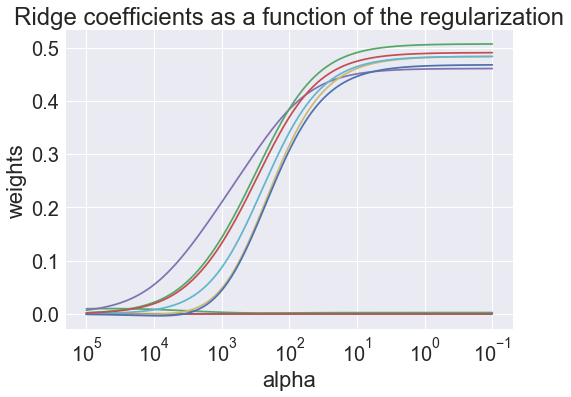

In [47]:
y2 = y_train.values
y3 = y2.reshape(17291,)
n_alphas = 200
alphas = np.logspace(-1, 5, n_alphas)

coefs = []
for a in alphas:
    ridge2 = Ridge(alpha=a, fit_intercept=False)
    ridge2.fit(X_train, y3)
    coefs.append(ridge2.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [48]:
print('Estimated intercept:', ridge.intercept_)
print('R-squared:', ridge.score(X_test_r, y_test_r))

Estimated intercept: [ 0.30236018]
R-squared: 0.757363542227


R-square for the ridge is a comfortable 0.75, which isn't bad!

In [49]:
for idx, col_name in enumerate(X.columns):
    print("The coefficient for {} is {}".format(col_name, ridge.coef_[0][idx]))

The coefficient for duration is -0.04952230569353593
The coefficient for seniority is 0.049958088730611375
The coefficient for salary is 0.008044375358904161
The coefficient for customer_service is 0.0009761006033711565
The coefficient for data_science is -0.0027753429875482355
The coefficient for design is -0.000885573018436436
The coefficient for engineer is -0.0017455296174281134
The coefficient for marketing is -0.003614030338835075
The coefficient for sales is -0.07630587930805979


In [50]:
y_predict_r = ridge.predict(X_test_r)
regression_model_mse = mean_squared_error(y_predict_r, y_test_r)
regression_model_mse
math.sqrt(regression_model_mse)

0.10231288625754201

Low mean squared error is another good sign.

In [51]:
ridge.coef_.flatten()


array([-0.04952231,  0.04995809,  0.00804438,  0.0009761 , -0.00277534,
       -0.00088557, -0.00174553, -0.00361403, -0.07630588,  0.24825486,
       -0.17194898])

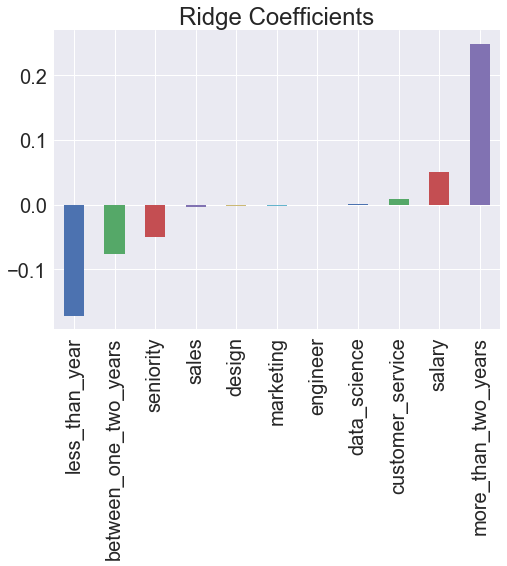

In [52]:
coef = pd.Series(ridge.coef_.flatten(), index = X2.columns)
coef = coef.sort_values()
coef.plot(kind='bar', title='Ridge Coefficients')

Here we can see that whether you last a certain amount of years greatly impacts your likelihood to quit, which is more important than salary or seniority that we found in the random forest.

#### Example of a predicted churn for specific employee:
'seniority','salary','customer_service','data_science','design','engineer','marketing','sales','between_one_two_years','more_than_two_years','less_than_year']]
For a customer_service employee with only 3 years work experience, a salary of $80,000 and has been at the company for less than a year:

In [54]:
a = pd.DataFrame([2,80000,1,0,0,0,0,0,0,0,1])
ridge.predict(a.transpose())

array([[ 3996.68650941]])

# Challenge 3) What would you add to make the model better?

I believe there could be a number of features that could be included in the dataset to better understand employee churn. Some of them are as follows:
* Employee satisfaction rating
* Did the employee get fired or leave on their own will?
* Some metric of work/life balance (avg hours of work per week)
* Did the employee get promoted at all during employment duration?
* If I had more time: I would create a metric regarding growth rate of the company at each day someone quit

Ultimately, I would choose the average hours of work per week as the one added feature that might be a strong indicator of retention - overworked employees can often only handle the workload for so long before they will look for better opportunities.